### Scripts Python : processing

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import pandas as pd
from preprocessing_function import *

##### Columns selection (MAJ possible selon les var pertinentes au modèle)

In [3]:
# Pour les nouvelles données
cols_kept = ['Année_construction',
            'Code_postal_(brut)',
            'Coût_total_5_usages',
            'Etiquette_DPE',
            'Etiquette_GES',
            'Hauteur_sous-plafond',
            'Logement',
            'Nombre_niveau_logement',
            'Surface_habitable_logement',
            'Type_bâtiment',
            'N°_département_(BAN)']


In [150]:
# # Pour les nouvelles données
# def cleaning_and_converting(new_data):
#     new_data.loc[:,"Besoin_ECS"] = new_data["Besoin_ECS"].apply(clean_and_convert)
#     new_data.loc[:,"Besoin_refroidissement"] = new_data["Besoin_refroidissement"].apply(clean_and_convert)
#     return new_data

##### **Embranchement 1** : Importation des données initiales et prétraitement (optimisé pour les débits internet limités)

In [5]:
# Importation des données
logements_neufs = pd.read_csv(os.path.join('..','m2-enedis__local','data','raw','neufs.csv'))
logements_existants = pd.read_csv(os.path.join('..','m2-enedis__local','data','raw','existents.csv'))

C:\Users\DELL\AppData\Local\Temp\ipykernel_3940\4135554626.py:2: DtypeWarning: Columns (80,100,111,112,132,133) have mixed types. Specify dtype option on import or set low_memory=False.
  logements_neufs = pd.read_csv(os.path.join('..','m2-enedis__local','data','raw','neufs.csv'))
C:\Users\DELL\AppData\Local\Temp\ipykernel_3940\4135554626.py:3: DtypeWarning: Columns (159,191,202,208,214,215,218,219,220,221,228,232) have mixed types. Specify dtype option on import or set low_memory=False.
  logements_existants = pd.read_csv(os.path.join('..','m2-enedis__local','data','raw','existents.csv'))


In [6]:
logements_existants["Année_construction"]

0         1965.0
1         1983.0
2         1990.0
3         1965.0
4         1983.0
           ...  
398109    1975.0
398110    1989.0
398111    1980.0
398112    1996.0
398113    1983.0
Name: Année_construction, Length: 398114, dtype: float64

In [152]:
import numpy as np

# Pour les anciens
logements_existants["Logement"] = "ancien"
distribution = logements_existants['Année_construction'].value_counts(normalize=True)

# Remplacer les valeurs manquantes en tirant aléatoirement basé sur la distribution
logements_existants['Année_construction'] = logements_existants['Année_construction'].apply(
    lambda x: np.random.choice(distribution.index, p=distribution.values) if pd.isnull(x) else x
)
# Pour les neufs (et les futures données qui seront produites)
logements_neufs = create_vars(logements_neufs)

In [153]:
logements_neufs = select_columns(logements_neufs, cols_kept)
logements_neufs.shape

(59213, 11)

In [154]:
logements_existants = select_columns(logements_existants, cols_kept)
logements_existants.shape

(398114, 11)

In [155]:
# logements_existants = cleaning_and_converting(logements_existants)
# logements_neufs = cleaning_and_converting(logements_neufs)

In [156]:
df = pd.concat([logements_existants, logements_neufs], ignore_index=True, axis=0)
df.columns

Index(['Année_construction', 'Code_postal_(brut)', 'Coût_total_5_usages',
       'Etiquette_DPE', 'Etiquette_GES', 'Hauteur_sous-plafond', 'Logement',
       'Nombre_niveau_logement', 'Surface_habitable_logement', 'Type_bâtiment',
       'N°_département_(BAN)'],
      dtype='object')

In [157]:
# A décommenter si on veut produire le csv du dataset déjà pré-traité
df = df[df["N°_département_(BAN)"].isin([22.0,29.0,35.0,56.0])] # Sélection des codes postaux d'intérêt
df = df.drop(["N°_département_(BAN)"], axis=1)
df.to_csv(os.path.join('data','processed','data_classification.csv'), index=False, sep=";", encoding="utf-8-sig")

##### **Embranchement 2** : Importation des données pré-traitées

In [158]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [159]:
import os 
import pandas as pd

df = pd.read_csv(os.path.join('data','processed','data_classification.csv'), sep=";")

##### Split train/test

In [160]:
X_train, X_test = data_split(df, target="Etiquette_DPE", test_size=0.3, stratify=True, seed=0)

##### Qualitative and quantitative data processing (after train/test split)

In [161]:
orig, new = quali_quanti_preprocessing_classif(X_train, X_test)

##### Split regressors/target

In [162]:
X_train, X_test, y_train, y_test = define_target(orig, new, target="Etiquette_DPE")

#### Split des données quanti et quali

In [163]:
to_drop = to_drop_before_model(case="classification")

In [164]:
quali_train, quali_test, quanti_train, quanti_test = split_type_classif(X_train, X_test, to_drop=[])

#### ACM

In [165]:
quali_train_mca, quali_test_mca =  chunking_MCA(quali_train, quali_test, n_components=10, n_iter=10, seed=0, chunk_size=1000)

MCA : fitting to train set
0.31326161730707786
0.6265232346141557
0.9397848519212335
MCA : transforming test set
0.36547036035377534
0.7309407207075507


In [166]:
X_train_mca, X_test_mca = merge_type_back(quali_train, quali_test, quanti_train, quanti_test, X_train.index, X_test.index)

### Standardisation

In [167]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

X_train_mca_scaled = pd.DataFrame(scaler.fit_transform(X_train_mca), index=X_train_mca.index, columns=X_train_mca.columns)
X_test_mca_scaled = pd.DataFrame(scaler.transform(X_test_mca), index=X_test_mca.index, columns=X_test_mca.columns)

### Feature selection

In [168]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=100, min_samples_split=5, random_state=0, verbose=1)
rf.fit(X_train_mca, y_train)
y_pred = rf.predict(X_test_mca)

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:   29.5s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    1.8s


In [169]:
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           A       0.97      0.96      0.96      8399
           B       0.91      0.90      0.91      7952
           C       0.94      0.97      0.95     41165
           D       0.90      0.89      0.89     38176
           E       0.87      0.87      0.87     24134
           F       0.85      0.81      0.83     10042
           G       0.89      0.82      0.85      6942

    accuracy                           0.91    136810
   macro avg       0.90      0.89      0.90    136810
weighted avg       0.91      0.91      0.91    136810



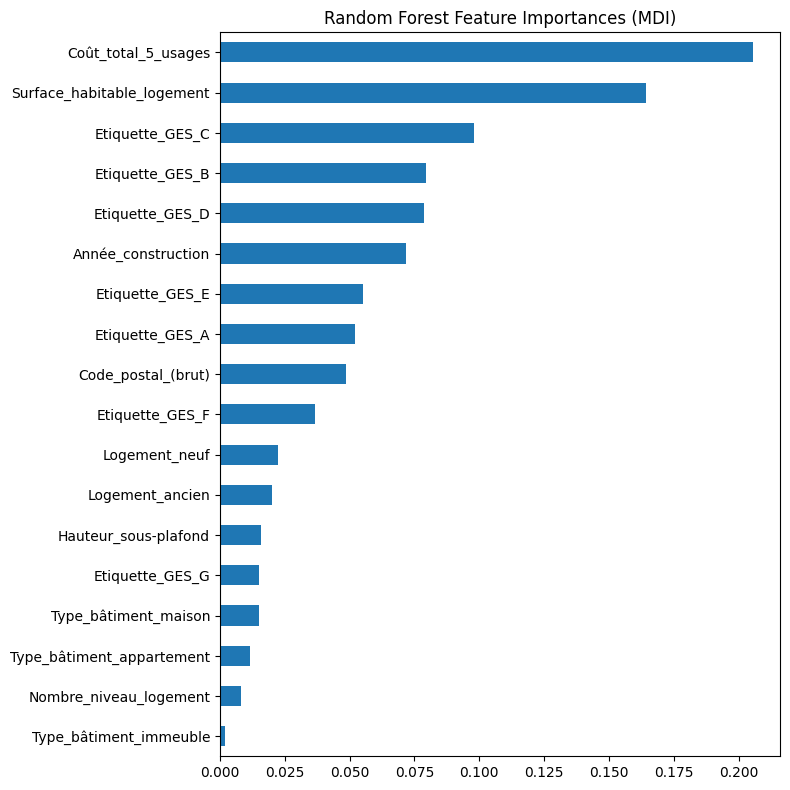

In [170]:
import pandas as pd
import matplotlib.pyplot as plt
plt.figure(figsize=(8,8))

feature_names = rf.feature_names_in_[:20]

mdi_importances = pd.Series(
    rf.feature_importances_[:20], index=feature_names
).sort_values(ascending=True)

ax = mdi_importances.plot.barh()
ax.set_title("Random Forest Feature Importances (MDI)")
ax.figure.tight_layout()

### Modélisation

In [171]:
# vars = ['Année_construction',
#         'Surface_habitable_logement',
#         'Coût_total_5_usages',
#         'Etiquette_GES',
#         'Code_postal_(brut)',
#         'Logement',
#         'Type_bâtiment',
#         'Hauteur_sous-plafond',
#         'Nombre_niveau_logement',
#         'Etiquette_DPE'
#         ]
# from sklearn.preprocessing import OneHotEncoder

# encoder = OneHotEncoder()

# encoder.fit(X_train[vars])

In [172]:
vars = ['Année_construction',
        'Code_postal_(brut)',
        'Coût_total_5_usages',
        'Hauteur_sous-plafond',
        'Nombre_niveau_logement',
        'Surface_habitable_logement',
        'Etiquette_GES_A',
        'Etiquette_GES_B',
        # 'Etiquette_GES_C',
        'Etiquette_GES_D',
        'Etiquette_GES_E',
        'Etiquette_GES_F',
        'Etiquette_GES_G',
        'Logement_neuf',
        # 'Type_bâtiment_appartement',
        'Type_bâtiment_immeuble',
        'Type_bâtiment_maison'
        ]

In [173]:
X_train_mca[vars].corr()

,Année_construction,Code_postal_(brut),Coût_total_5_usages,Hauteur_sous-plafond,Nombre_niveau_logement,Surface_habitable_logement,Etiquette_GES_A,Etiquette_GES_B,Etiquette_GES_D,Etiquette_GES_E,Etiquette_GES_F,Etiquette_GES_G,Logement_neuf,Type_bâtiment_immeuble,Type_bâtiment_maison
Année_construction,1.000000,0.051359,-0.111013,-0.001879,-0.019081,0.015214,0.245211,-0.076336,-0.132233,-0.127577,-0.106222,-0.070745,0.486561,0.011979,-0.028951
Code_postal_(brut),0.051359,1.000000,-0.019620,-0.000504,0.019327,0.005207,0.042323,-0.007832,-0.039017,-0.015315,-0.023701,-0.017238,0.052291,0.005566,-0.017317
Coût_total_5_usages,-0.111013,-0.019620,1.000000,-0.000029,0.010576,0.236444,-0.110137,-0.021192,0.045407,0.074316,0.102945,0.093552,-0.120713,0.527211,0.092540
Hauteur_sous-plafond,-0.001879,-0.000504,-0.000029,1.000000,-0.000278,-0.000248,0.000307,-0.001868,-0.000832,-0.000535,-0.000100,-0.000155,0.001800,-0.000372,-0.001298
Nombre_niveau_logement,-0.019081,0.019327,0.010576,-0.000278,1.000000,0.032492,-0.016339,0.001816,-0.003339,0.010348,0.010888,0.005577,-0.025567,-0.015202,0.049224
Surface_habitable_logement,0.015214,0.005207,0.236444,-0.000248,0.032492,1.000000,0.071968,-0.058199,0.010252,0.041075,0.045601,0.014444,0.067193,0.161407,0.307903
Etiquette_GES_A,0.245211,0.042323,-0.110137,0.000307,-0.016339,0.071968,1.000000,-0.306384,-0.190118,-0.129148,-0.095595,-0.061248,0.307602,-0.029367,0.127084
Etiquette_GES_B,-0.076336,-0.007832,-0.021192,-0.001868,0.001816,-0.058199,-0.306384,1.000000,-0.231985,-0.157588,-0.116646,-0.074736,-0.118170,-0.016147,0.036416
Etiquette_GES_D,-0.132233,-0.039017,0.045407,-0.000832,-0.003339,0.010252,-0.190118,-0.231985,1.000000,-0.097787,-0.072381,-0.046375,-0.146084,0.007100,-0.059955
Etiquette_GES_E,-0.127577,-0.015315,0.074316,-0.000535,0.010348,0.041075,-0.129148,-0.157588,-0.097787,1.000000,-0.049169,-0.031503,-0.099502,-0.009525,0.063202


In [174]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=10, min_samples_split=5, max_depth=None, random_state=0, verbose=1)
rf.fit(X_train_mca[vars], y_train)
y_pred = rf.predict(X_test_mca[vars])

In [175]:
"""from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold

rf = RandomForestClassifier()
cv = StratifiedKFold(5)
params = {'n_estimators': [100],
          'min_samples_split': [5],
          'max_depth': [20, None]}
grid = GridSearchCV(rf, param_grid=params, scoring="accuracy", cv=cv, verbose=2)
grid.fit(X_train_mca[vars], y_train)"""

'from sklearn.ensemble import RandomForestClassifier\nfrom sklearn.model_selection import GridSearchCV, StratifiedKFold\n\nrf = RandomForestClassifier()\ncv = StratifiedKFold(5)\nparams = {\'n_estimators\': [100],\n          \'min_samples_split\': [5],\n          \'max_depth\': [20, None]}\ngrid = GridSearchCV(rf, param_grid=params, scoring="accuracy", cv=cv, verbose=2)\ngrid.fit(X_train_mca[vars], y_train)'

In [176]:
# Quali OHE
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           A       0.96      0.96      0.96      8399
           B       0.90      0.89      0.89      7952
           C       0.93      0.97      0.95     41165
           D       0.89      0.88      0.88     38176
           E       0.86      0.86      0.86     24134
           F       0.83      0.79      0.81     10042
           G       0.86      0.81      0.83      6942

    accuracy                           0.90    136810
   macro avg       0.89      0.88      0.88    136810
weighted avg       0.90      0.90      0.90    136810



In [177]:
# Sans quali OHE
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           A       0.96      0.96      0.96      8399
           B       0.90      0.89      0.89      7952
           C       0.93      0.97      0.95     41165
           D       0.89      0.88      0.88     38176
           E       0.86      0.86      0.86     24134
           F       0.83      0.79      0.81     10042
           G       0.86      0.81      0.83      6942

    accuracy                           0.90    136810
   macro avg       0.89      0.88      0.88    136810
weighted avg       0.90      0.90      0.90    136810



In [178]:
# Emission_GES_ECS
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           A       0.96      0.96      0.96      8399
           B       0.90      0.89      0.89      7952
           C       0.93      0.97      0.95     41165
           D       0.89      0.88      0.88     38176
           E       0.86      0.86      0.86     24134
           F       0.83      0.79      0.81     10042
           G       0.86      0.81      0.83      6942

    accuracy                           0.90    136810
   macro avg       0.89      0.88      0.88    136810
weighted avg       0.90      0.90      0.90    136810



In [179]:
# Etiquettes GES A + G
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           A       0.96      0.96      0.96      8399
           B       0.90      0.89      0.89      7952
           C       0.93      0.97      0.95     41165
           D       0.89      0.88      0.88     38176
           E       0.86      0.86      0.86     24134
           F       0.83      0.79      0.81     10042
           G       0.86      0.81      0.83      6942

    accuracy                           0.90    136810
   macro avg       0.89      0.88      0.88    136810
weighted avg       0.90      0.90      0.90    136810



In [180]:
# Etiquettes GES A - G
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           A       0.96      0.96      0.96      8399
           B       0.90      0.89      0.89      7952
           C       0.93      0.97      0.95     41165
           D       0.89      0.88      0.88     38176
           E       0.86      0.86      0.86     24134
           F       0.83      0.79      0.81     10042
           G       0.86      0.81      0.83      6942

    accuracy                           0.90    136810
   macro avg       0.89      0.88      0.88    136810
weighted avg       0.90      0.90      0.90    136810



In [181]:
# 50 arbres
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           A       0.96      0.96      0.96      8399
           B       0.90      0.89      0.89      7952
           C       0.93      0.97      0.95     41165
           D       0.89      0.88      0.88     38176
           E       0.86      0.86      0.86     24134
           F       0.83      0.79      0.81     10042
           G       0.86      0.81      0.83      6942

    accuracy                           0.90    136810
   macro avg       0.89      0.88      0.88    136810
weighted avg       0.90      0.90      0.90    136810



In [182]:
# 20 arbres
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           A       0.96      0.96      0.96      8399
           B       0.90      0.89      0.89      7952
           C       0.93      0.97      0.95     41165
           D       0.89      0.88      0.88     38176
           E       0.86      0.86      0.86     24134
           F       0.83      0.79      0.81     10042
           G       0.86      0.81      0.83      6942

    accuracy                           0.90    136810
   macro avg       0.89      0.88      0.88    136810
weighted avg       0.90      0.90      0.90    136810



In [183]:
# 10 arbres
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           A       0.96      0.96      0.96      8399
           B       0.90      0.89      0.89      7952
           C       0.93      0.97      0.95     41165
           D       0.89      0.88      0.88     38176
           E       0.86      0.86      0.86     24134
           F       0.83      0.79      0.81     10042
           G       0.86      0.81      0.83      6942

    accuracy                           0.90    136810
   macro avg       0.89      0.88      0.88    136810
weighted avg       0.90      0.90      0.90    136810



In [184]:
# 5 arbres
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           A       0.96      0.96      0.96      8399
           B       0.90      0.89      0.89      7952
           C       0.93      0.97      0.95     41165
           D       0.89      0.88      0.88     38176
           E       0.86      0.86      0.86     24134
           F       0.83      0.79      0.81     10042
           G       0.86      0.81      0.83      6942

    accuracy                           0.90    136810
   macro avg       0.89      0.88      0.88    136810
weighted avg       0.90      0.90      0.90    136810



In [185]:
"""import pandas as pd
import matplotlib.pyplot as plt
plt.figure(figsize=(8,8))

feature_names = rf.feature_names_in_

mdi_importances = pd.Series(
    rf.feature_importances_, index=feature_names
).sort_values(ascending=True)

ax = mdi_importances.plot.barh()
ax.set_title("Random Forest Feature Importances (MDI)")
ax.figure.tight_layout()"""

'import pandas as pd\nimport matplotlib.pyplot as plt\nplt.figure(figsize=(8,8))\n\nfeature_names = rf.feature_names_in_\n\nmdi_importances = pd.Series(\n    rf.feature_importances_, index=feature_names\n).sort_values(ascending=True)\n\nax = mdi_importances.plot.barh()\nax.set_title("Random Forest Feature Importances (MDI)")\nax.figure.tight_layout()'

In [186]:
import pickle as pk

pk.dump(rf, open(os.path.join("models","rf_tuned_classification.pkl"), "wb"))

In [187]:
# TEST PIPELINE
from pipeline import Pipeline_classification

new = pd.DataFrame([{"Année_construction":2024,
                     "Surface_habitable_logement":200,
                     "Coût_total_5_usages":10000,
                     "Etiquette_GES":"B",
                     "Code_postal_(brut)":35660,
                     "Logement":"neuf",
                     "Type_bâtiment":"maison",
                     "Hauteur_sous-plafond":3,
                     "Nombre_niveau_logement":2
                     }])

Pipeline_classification(new)

['B']


### Régression

In [188]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [243]:
# Importation des données
# logements_neufs = pd.read_csv(os.path.join('data','raw','neufs.csv'))
# logements_existants = pd.read_csv(os.path.join('data','raw','existents.csv'))

In [265]:
cols_kept = ['Année_construction',
            'Code_postal_(brut)',
            'Coût_total_5_usages',
            'Etiquette_DPE',
            # 'Etiquette_GES',
            'Hauteur_sous-plafond',
            'Logement',
            'Nombre_niveau_logement',
            'Surface_habitable_logement',
            'Type_bâtiment',
            'N°_département_(BAN)']

In [266]:
logements_neufs = select_columns(logements_neufs, cols_kept)
logements_neufs.shape

logements_existants = select_columns(logements_existants, cols_kept)
logements_existants.shape

(398114, 10)

In [267]:
# logements_existants = cleaning_and_converting(logements_existants)
# logements_neufs = cleaning_and_converting(logements_neufs)

In [268]:
df = pd.concat([logements_existants, logements_neufs], ignore_index=True, axis=0)

In [269]:
# A décommenter si on veut produire le csv du dataset déjà pré-traité
df = df[df["N°_département_(BAN)"].isin([22.0,29.0,35.0,56.0])] # Sélection des codes postaux d'intérêt
df = df.drop(["N°_département_(BAN)"],axis=1)
df.to_csv(os.path.join('data','processed','data_regression.csv'), index=False, sep=";", encoding="utf-8-sig")

In [270]:
df['Coût_total_5_usages'] = df['Coût_total_5_usages'].fillna(df['Coût_total_5_usages'].median())

In [271]:
X_train, X_test = data_split(df, target="Coût_total_5_usages", test_size=0.3, stratify=False, seed=0)

In [272]:
X_test.columns

Index(['Année_construction', 'Code_postal_(brut)', 'Coût_total_5_usages',
       'Etiquette_DPE', 'Hauteur_sous-plafond', 'Logement',
       'Nombre_niveau_logement', 'Surface_habitable_logement',
       'Type_bâtiment'],
      dtype='object')

##### Qualitative and quantitative data processing (after train/test split)

In [273]:
orig, new = quali_quanti_preprocessing_regression(X_train, X_test)

In [274]:
orig["Coût_total_5_usages"]

120688     771.3
194074    1053.2
390534    1136.5
309668     861.3
393549     639.0
           ...  
152620    3240.9
440401    4746.0
118241    1038.2
437123     243.1
306785     744.9
Name: Coût_total_5_usages, Length: 319222, dtype: float64

##### Split regressors/target

In [275]:
X_train, X_test, y_train, y_test = define_target(orig, new, target="Coût_total_5_usages")

#### Split des données quanti et quali

In [276]:
X_test

,Année_construction,Code_postal_(brut),Etiquette_DPE,Hauteur_sous-plafond,Logement,Nombre_niveau_logement,Surface_habitable_logement,Type_bâtiment
89480,1993.0,29200.0,D,2.5,ancien,1.0,39.0,appartement
24669,1979.0,22220.0,G,2.8,ancien,1.0,62.8,maison
77713,1955.0,29150.0,F,2.6,ancien,1.0,97.4,maison
127838,1970.0,29420.0,D,2.5,ancien,2.0,90.0,maison
66106,2008.0,29000.0,E,2.8,ancien,1.0,77.4,appartement
...,...,...,...,...,...,...,...,...
150010,1989.0,29700.0,D,2.5,ancien,1.0,50.3,appartement
264700,1991.0,35410.0,C,2.5,ancien,2.0,111.2,maison
107314,1950.0,29200.0,E,2.6,ancien,4.0,71.7,appartement
304018,1947.0,35720.0,D,2.5,ancien,2.0,74.3,maison


In [277]:
quali_train, quali_test, quanti_train, quanti_test = split_type_regression(X_train, X_test, to_drop=[])

In [278]:
X_train_mca, X_test_mca = merge_type_back(quali_train, quali_test, quanti_train, quanti_test, X_train.index, X_test.index)

In [279]:
vars = ['Année_construction',
        'Code_postal_(brut)',
        'Hauteur_sous-plafond',
        'Nombre_niveau_logement',
        'Surface_habitable_logement',
        'Etiquette_DPE_A',
        'Etiquette_DPE_B',
        # 'Etiquette_DPE_C',
        'Etiquette_DPE_D',
        'Etiquette_DPE_E',
        'Etiquette_DPE_F',
        'Etiquette_DPE_G',
        # 'Etiquette_GES_A',
        # 'Etiquette_GES_B',
        # # 'Etiquette_GES_C',
        # 'Etiquette_GES_D',
        # 'Etiquette_GES_E',
        # 'Etiquette_GES_F',
        # 'Etiquette_GES_G',
        'Logement_neuf',
        # 'Type_bâtiment_appartement',
        'Type_bâtiment_immeuble',
        'Type_bâtiment_maison'
        ]

In [280]:
X_train_mca[vars].corr()

,Année_construction,Code_postal_(brut),Hauteur_sous-plafond,Nombre_niveau_logement,Surface_habitable_logement,Etiquette_DPE_A,Etiquette_DPE_B,Etiquette_DPE_D,Etiquette_DPE_E,Etiquette_DPE_F,Etiquette_DPE_G,Logement_neuf,Type_bâtiment_immeuble,Type_bâtiment_maison
Année_construction,1.000000,0.050570,-0.000514,-0.019627,0.013501,0.301045,0.193550,-0.142058,-0.189420,-0.158721,-0.146246,0.485963,0.011602,-0.029381
Code_postal_(brut),0.050570,1.000000,-0.000418,0.019212,0.005621,0.041404,0.008246,-0.025586,-0.020707,-0.027716,-0.031438,0.050553,0.007308,-0.016369
Hauteur_sous-plafond,-0.000514,-0.000418,1.000000,-0.000373,0.000264,0.005769,-0.001234,-0.001938,-0.001745,0.005425,-0.000410,0.004094,-0.000421,-0.000155
Nombre_niveau_logement,-0.019627,0.019212,-0.000373,1.000000,0.031263,-0.025374,0.001433,-0.004743,0.009941,0.007555,0.002338,-0.025407,-0.015244,0.049545
Surface_habitable_logement,0.013501,0.005621,0.000264,0.031263,1.000000,0.104502,0.040168,-0.024427,-0.021305,0.006209,-0.026946,0.061370,0.142692,0.298326
Etiquette_DPE_A,0.301045,0.041404,0.005769,-0.025374,0.104502,1.000000,-0.063577,-0.159517,-0.118593,-0.071947,-0.059202,0.560687,-0.023595,0.221285
Etiquette_DPE_B,0.193550,0.008246,-0.001234,0.001433,0.040168,-0.063577,1.000000,-0.154714,-0.115023,-0.069781,-0.057420,0.276068,-0.004309,-0.003658
Etiquette_DPE_D,-0.142058,-0.025586,-0.001938,-0.004743,-0.024427,-0.159517,-0.154714,1.000000,-0.288595,-0.175081,-0.144067,-0.239033,-0.007571,-0.045460
Etiquette_DPE_E,-0.189420,-0.020707,-0.001745,0.009941,-0.021305,-0.118593,-0.115023,-0.288595,1.000000,-0.130165,-0.107108,-0.178504,-0.010972,0.080939
Etiquette_DPE_F,-0.158721,-0.027716,0.005425,0.007555,0.006209,-0.071947,-0.069781,-0.175081,-0.130165,1.000000,-0.064979,-0.108339,-0.012072,0.113441


In [281]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(n_estimators=50, min_samples_split=5, max_depth=None, random_state=0, verbose=1)
rf.fit(X_train_mca[vars], y_train)
y_pred = rf.predict(X_test_mca[vars])

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:  1.1min
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    2.9s


In [282]:
"""from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV, KFold

rf = RandomForestRegressor()
cv = KFold(5)
params = {'n_estimators': [10,50,100],
          'min_samples_split': [5],
          'max_depth': [10, None],
          'criterion': ["absolute_error"]}
grid = GridSearchCV(rf, param_grid=params, scoring="neg_mean_absolute_error", cv=cv, verbose=2)
grid.fit(X_train_mca[vars], y_train)"""

'from sklearn.ensemble import RandomForestRegressor\nfrom sklearn.model_selection import GridSearchCV, KFold\n\nrf = RandomForestRegressor()\ncv = KFold(5)\nparams = {\'n_estimators\': [10,50,100],\n          \'min_samples_split\': [5],\n          \'max_depth\': [10, None],\n          \'criterion\': ["absolute_error"]}\ngrid = GridSearchCV(rf, param_grid=params, scoring="neg_mean_absolute_error", cv=cv, verbose=2)\ngrid.fit(X_train_mca[vars], y_train)'

In [283]:
# Avec DPE
from sklearn.metrics import root_mean_squared_error, mean_absolute_error

print(mean_absolute_error(y_test, y_pred))
print(root_mean_squared_error(y_test, y_pred))

270.5596738731614
1787.024050857999


In [284]:
new = pd.DataFrame([{"Année_construction":2024,
                     "Surface_habitable_logement":200,
                     "Etiquette_DPE":"B",
                     "Code_postal_(brut)":35660,
                     "Logement":"neuf",
                     "Type_bâtiment":"maison",
                     "Hauteur_sous-plafond":3,
                     "Nombre_niveau_logement":2
                     }])

In [285]:
from pipeline import Pipeline_regression
Pipeline_regression(new)

[1231.913125]


### Création du csv pour la carte des données

In [286]:
# Importation des données
logements_neufs = pd.read_csv(os.path.join('data','raw','neufs.csv'))
logements_existants = pd.read_csv(os.path.join('data','raw','existents.csv'))

C:\Users\Evidya\AppData\Local\Temp\ipykernel_16980\1169846585.py:2: DtypeWarning: Columns (80,100,111,112,132,133) have mixed types. Specify dtype option on import or set low_memory=False.
  logements_neufs = pd.read_csv(os.path.join('data','raw','neufs.csv'))
C:\Users\Evidya\AppData\Local\Temp\ipykernel_16980\1169846585.py:3: DtypeWarning: Columns (159,191,202,208,214,215,218,219,220,221,228,232) have mixed types. Specify dtype option on import or set low_memory=False.
  logements_existants = pd.read_csv(os.path.join('data','raw','existents.csv'))


In [287]:
df = pd.concat([logements_existants, logements_neufs], ignore_index=True, axis=0)


df[["lat","lon"]] = df["_geopoint"].str.split(",", expand=True)
df["lon"] = pd.to_numeric(df["lon"])
df["lat"] = pd.to_numeric(df["lat"])
df = df[["lon","lat","Type_bâtiment","Surface_habitable_logement","Etiquette_DPE"]]

C:\Users\Evidya\AppData\Local\Temp\ipykernel_16980\3804064002.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[["lat","lon"]] = df["_geopoint"].str.split(",", expand=True)
C:\Users\Evidya\AppData\Local\Temp\ipykernel_16980\3804064002.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[["lat","lon"]] = df["_geopoint"].str.split(",", expand=True)


In [288]:
# Preprocessing des données map

def map_preprocessing(data):
    import pandas as pd
    
    # QUALITATIVE PREPROCESSING

    quali_data = data.select_dtypes(include=['object'])
    for column in quali_data.columns:
        # Calcul de la proportion (probabilité) des modalités dans chaque variable qualitative
        proportions = data[column].value_counts(normalize=True)
        
        # On applique la fonction à la colonne
        filling = proportions.sample(weights=proportions, replace=True).index[0]
        data[column] = data[column].fillna(filling)
        filling = proportions.sample(weights=proportions, replace=True).index[0]
        quali_data[column] = quali_data[column].fillna(filling)
    

    # QUANTITATIVE PREPROCESSING
    ## Missing values
    from sklearn.impute import SimpleImputer
    imputer = SimpleImputer(strategy="median")

    quanti_data = data.select_dtypes(exclude=['object'])
    quanti_data[quanti_data.columns] = imputer.fit_transform(quanti_data)

    new_data_processed = pd.concat([quali_data, quanti_data], axis=1)
    return new_data_processed

In [289]:
data_map = map_preprocessing(df)

In [290]:
data_map.to_csv(os.path.join("data","processed","data_map.csv"),index=False, sep=";", encoding="utf-8-sig")

In [291]:
# TEST MAP
from mapping import generate_map

df = pd.read_csv(os.path.join("data","processed","data_map.csv"), sep=";", encoding="utf-8-sig")

generate_map(df.sample(10000))